In [257]:
import numpy as np
from skimage import draw

import scipy
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from PIL import Image

%matplotlib inline
plt.rc("figure", figsize=(16, 8))

In [266]:
person = np.asarray(Image.open('person.png').convert('L'))
people = np.asarray(Image.open('people.png').convert('L'))
people2 = np.asarray(Image.open('people2.png').convert('L'))

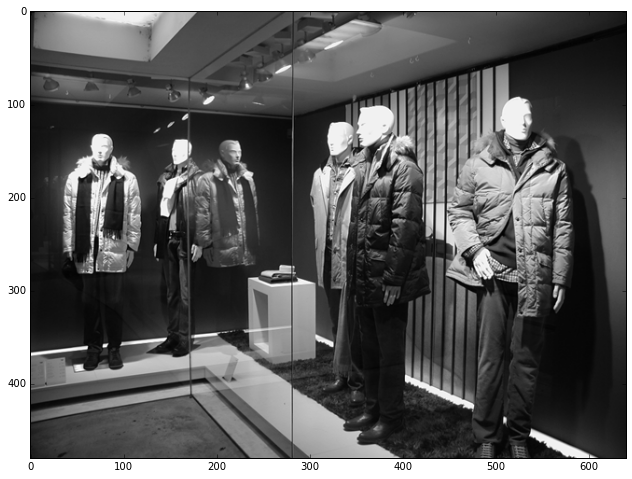

In [268]:
plt.imshow(people, cmap=plt.cm.gray)

In [216]:
hog_size = 8
num_bins = 9

In [217]:
angle_map = np.linspace(0, np.pi, num_bins)

In [255]:
def hog_cells(image):
    kernel_x = np.array([[-1, 0, 1]])
    kernel_y = np.array([[-1], [0], [1]])
    grad_x = signal.convolve2d(np.asarray(image), kernel_x, boundary='fill', mode='same')
    grad_y = signal.convolve2d(np.asarray(image), kernel_y, boundary='fill', mode='same')
    angles = np.arctan2(grad_y, grad_x) % np.pi
    hog = np.zeros((angles.shape[0] // hog_size, angles.shape[1] // hog_size, num_bins))
    for r_i, r in enumerate(range(0, angles.shape[0], hog_size)):
        for c_i, c in enumerate(range(0, angles.shape[1], hog_size)):
            window = angles[r:r+hog_size, c:c+hog_size]
            bins, _ = np.histogram(window, bins=num_bins, range=(0, np.pi))
            hog[r_i, c_i] = bins
    return hog

In [226]:
vis_size = 31

In [227]:
def draw_hog(hog, hog_size, vis_size, plot_all=False):
    hog_image = np.zeros((hog.shape[0] * vis_size, hog.shape[1] * vis_size))
    for r_i, r in enumerate(range(0, hog_image.shape[0], vis_size)):
        for c_i, c in enumerate(range(0, hog_image.shape[1], vis_size)):
            center = (r + vis_size // 2, c + vis_size // 2)
            bin_indices = range(num_bins) if plot_all else [np.argmax(hog[r_i, c_i])]
            for bin_idx in bin_indices:
                angle = angle_map[bin_idx]
                length = (vis_size - 1) // 2 / hog_size ** 2 * hog[r_i, c_i, bin_idx]
                lr = int(np.sin(angle) * length)
                lc = int(np.cos(angle) * length)
                rr, cc, val = draw.line_aa(-lr, -lc, lr, lc)
                hog_image[rr + center[0], cc + center[1]] = val
    return hog_image

In [228]:
person_cells = hog_cells(person)

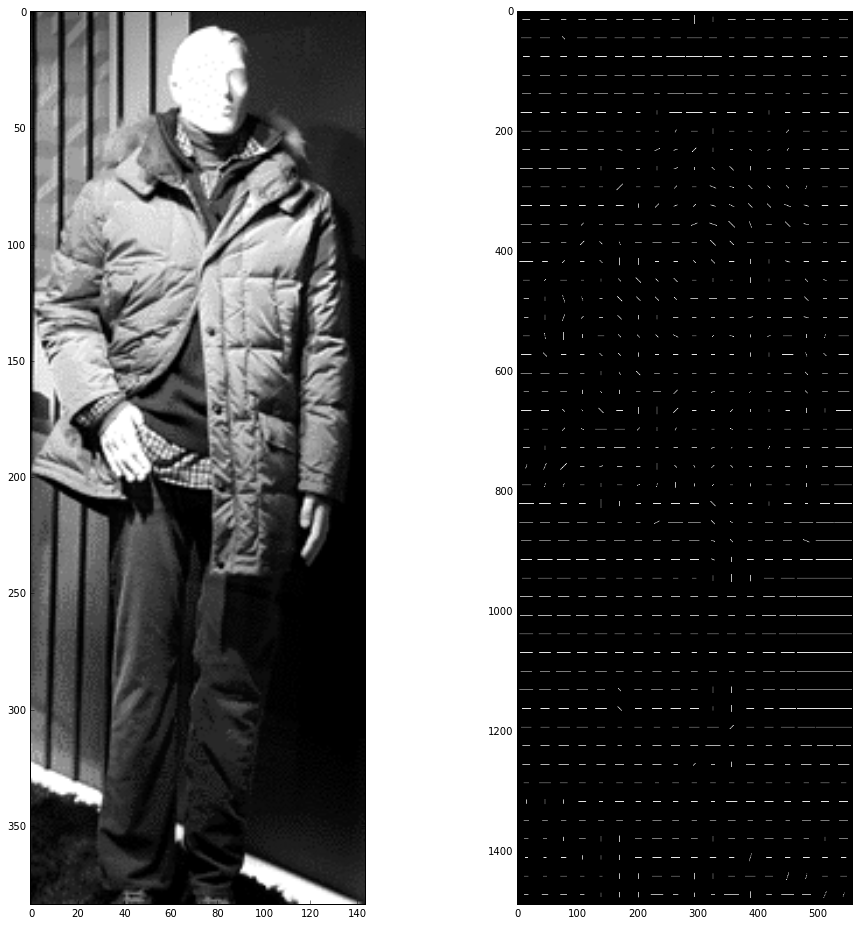

In [230]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(121)
ax1.imshow(person, cmap=plt.cm.gray)
ax1 = fig.add_subplot(122)
ax1.imshow(draw_hog(person_cells, hog_size, vis_size), cmap=plt.cm.gray)

In [231]:
block_size = hog_size * 2

In [238]:
def hog_blocks(hog_mask, nb_cells=2):
    blocks = np.zeros((hog_mask.shape[0] - 1, hog_mask.shape[1] - 1, num_bins))
    for r_i, r in enumerate(range(0, blocks.shape[0])):
        for c_i, c in enumerate(range(0, blocks.shape[1])):
            blocks[r_i, c_i] = np.sum(hog_mask[r:r+nb_cells, c:c+nb_cells], axis=(0, 1))
    return blocks

def hog(image):
    return hog_blocks(hog_cells(image))

In [236]:
blocks = hog_blocks(person_cells)

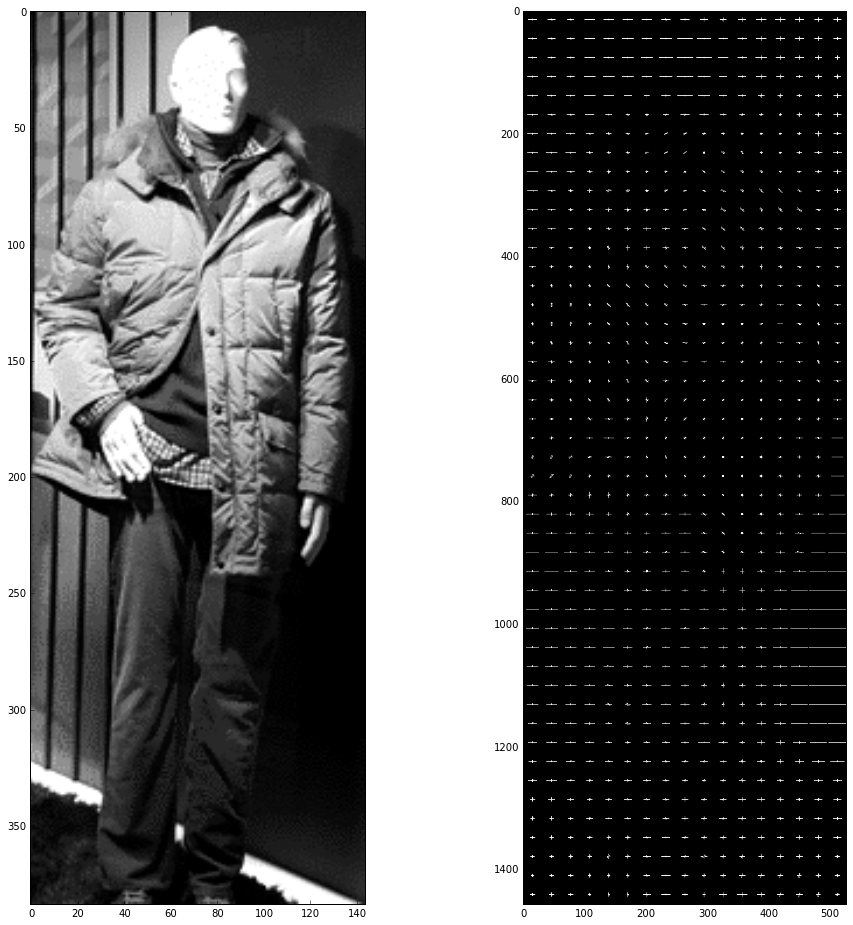

In [237]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(121)
ax1.imshow(person, cmap=plt.cm.gray)
ax1 = fig.add_subplot(122)
ax1.imshow(draw_hog(blocks, block_size, vis_size, plot_all=True), cmap=plt.cm.gray)

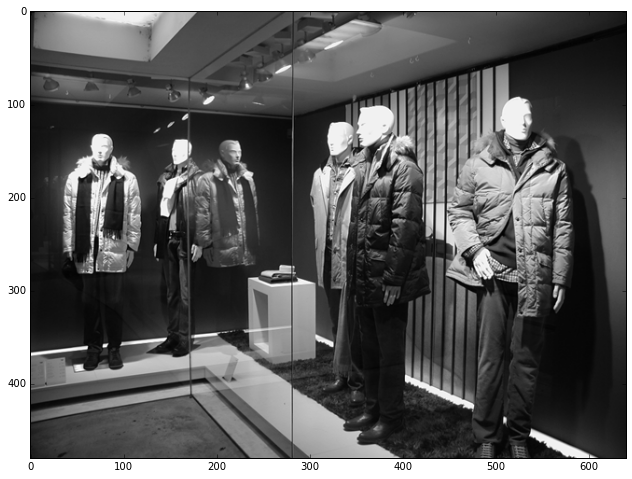

In [215]:
np.array(people).shape
plt.imshow(people, 'gray')
plt.show()

In [249]:
def hog_compare(mask_blocks, image):
    image_blocks = hog(image)
    return np.mean((mask_blocks - image_blocks)**2)

In [252]:
def hog_find(mask, image, step = 8):
    mask_cells = hog_cells(mask)
    mask_blocks = hog_blocks(mask_cells)
    h_heigth = mask.shape[0]
    h_width = mask.shape[1]
    best_pos = (0, 0)
    best_score = np.inf
    for r in range(0, image.shape[0] - h_heigth, step):
        for c in range(0, image.shape[1] - h_width, step):
            subimage = image[r:r+h_heigth, c:c+h_width]
            score = hog_compare(mask_blocks, subimage)
            if score < best_score:
                best_pos = (r, c)
                best_score = score
    r, c = best_pos
    return best_pos, best_score, image[r:r+h_heigth, c:c+h_width]

In [ ]:
def draw_bounding_box(minr, minc, maxr, maxc, ax):
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)    

In [284]:
def find_and_visualise(mask, image):
    pos, score, found_image = hog_find(mask, image, step=8)
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    draw_bounding_box(pos[0], pos[1], pos[0]+mask.shape[0], pos[1]+mask.shape[1], ax)

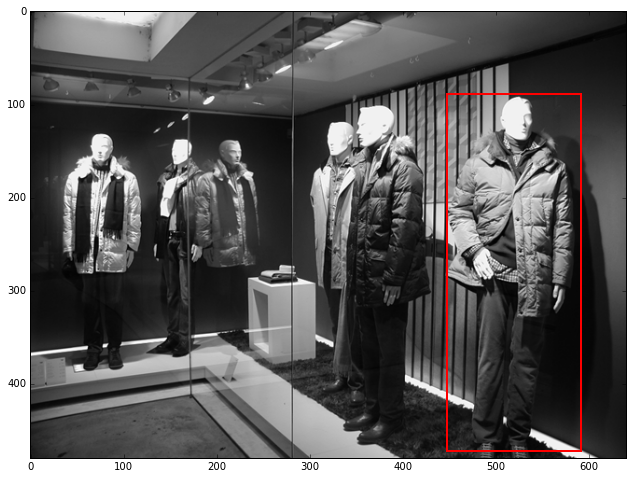

In [285]:
find_and_visualise(person, people)

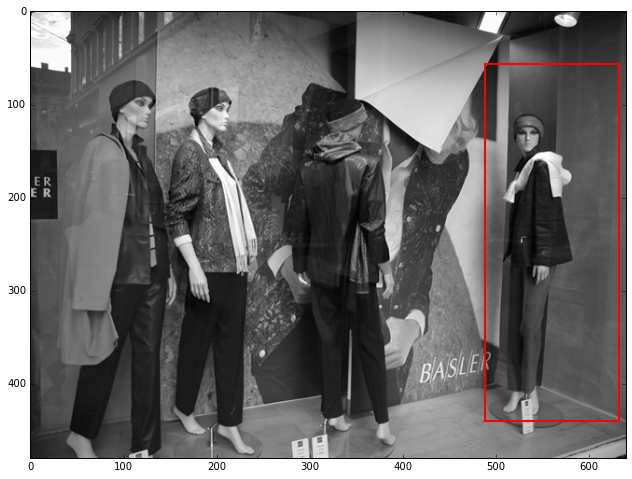

In [286]:
find_and_visualise(person, people2)